<a href="https://colab.research.google.com/github/hsleonis/machine-learning/blob/master/DS_student_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer#for word embedding
import gensim
from gensim.models import Word2Vec, FastText

In [2]:
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv1D, Flatten, Dropout, Embedding, Bidirectional, LSTM
from tensorflow.keras.preprocessing import sequence, text
from tensorflow.keras.utils import to_categorical, plot_model
from collections import Counter

In [3]:
%cd /content/drive/MyDrive/labtwinds/

/content/drive/MyDrive/labtwinds


Download stopwords:

In [4]:
nltk.data.path.append('/content/drive/MyDrive/labtwinds/')

In [5]:
nltk.download('stopwords', download_dir='/content/drive/MyDrive/labtwinds/')
nltk.download('punkt', download_dir='/content/drive/MyDrive/labtwinds/')

[nltk_data] Downloading package stopwords to
[nltk_data]     /content/drive/MyDrive/labtwinds/...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /content/drive/MyDrive/labtwinds/...
[nltk_data]   Package punkt is already up-to-date!


True

### **Import Data**

#### **Training Data**

Load **terms.pkl**, **labels.pkl** and check if number of instances are equal.

In [8]:
terms = pd.read_pickle("terms.pkl")
labels = pd.read_pickle("labels.pkl")

'True' if len(terms) == len(labels) else 'False'

'True'

Create a dataframe for easier data manipulation:

In [9]:
df = pd.DataFrame(data={'term':terms, 'label':labels })
df.head()

,term,label
0,celesticetin,antibiotic
1,aminocoumarin resistant gyrB,antibiotic
2,BPI,antibiotic
3,AxyXY-OprZ,antibiotic
4,ANT(2''),antibiotic


#### **Prediction Data**

In [10]:
texts = pd.read_pickle("texts.pkl")
df_test = pd.DataFrame(data={'term':texts})
df_test.head()

,term
0,[No Results]
1,"[DNA gyrase, or simply gyrase, is an enzyme wi..."
2,[DisambiguationError]
3,[No Results]
4,[Ant-Man and the Wasp: Quantumania is an upcom...


### **Exploratory Data Analysis**:

1. **Class distribution:**

In [11]:
len(df)

11987

We have **11987** rows in the training dataset. Let's look at different categories:

non_science    6000
reagent        1300
protein        1300
drug           1300
cell           1300
antibiotic      787
Name: label, dtype: int64


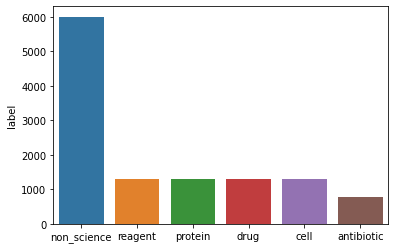

In [12]:
x = df['label'].value_counts()
print(x)

sns.barplot(x=x.index, y=x)

There are **6000** labels with class 'non_science'. Other categories have similar number of labels.

2. **Missing values:**

In [13]:
df.isna().sum()

term     0
label    0
dtype: int64

We do not have any missing values in training set.

In [14]:
df_test.isna().sum()

term    0
dtype: int64

3. **Dataset balancing**:

In [16]:
print('non_science: ', len(df[df['label'] == 'non_science']))
print('other:       ', len(df[df['label'] != 'non_science']))

non_science:  6000
other:        5987


We can say that the dataset is relatively balanced as the other categories have almost 6000 labels combined.

4. **Number of words**:

In [17]:
# WORD-COUNT
df['word_count'] = df['term'].apply(lambda x: len(str(x).split()))

print(df[df['label'] == 'non_science']['word_count'].mean()) # non_science
print(df[df['label'] != 'non_science']['word_count'].mean()) # other

2.9155
3.500250542842826


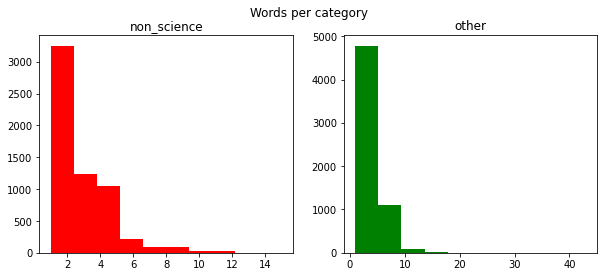

In [18]:
# PLOTTING WORD-COUNT
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4))

ax1.hist(df[df['label'] == 'non_science']['word_count'], color='red')
ax1.set_title('non_science')

ax2.hist(df[df['label'] != 'non_science']['word_count'], color='green')
ax2.set_title('other')
fig.suptitle('Words per category')
plt.show()

Compare word count in training and prediction dataset:

In [19]:
df_test['word_count'] = df_test['term'].apply(lambda x: len(str(x).split()))

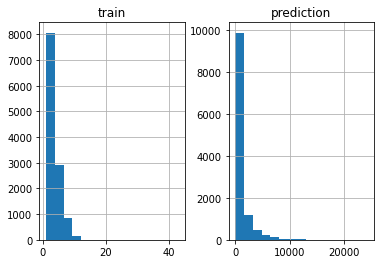

In [20]:
length_df = pd.DataFrame({'train': df['word_count'], 'prediction': df_test['word_count']})
length_df.hist(bins=15)
plt.show()

Number of words in prediction dataset is significantly large.

Let's take a suitable number of words which covers maximum percentage of the prediction data.

In [21]:
# maximum word count
maxlen = 900

count = 0
for i in df_test['word_count']:
    if(i <= maxlen):
        count += 1
print(count/len(df_test['word_count']))

0.715525152248269


Taking word length to 900 covers 70% of prediction set.

### **Data preparation**:

#### **Text cleaning**:

We do not require semtiments or numbers. Hence, we can remove all stopwords, punctuations and numbers from text.

In [38]:
# remove stopwords
def stopword(str):
    a = [i for i in str.split() if i not in stopwords.words('english')]
    return ' '.join(a)

# convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower()
    text = re.sub("[^a-zA-Z]", " ", text)
    text = text.strip()
    return stopword(text)

In [39]:
df['clean_text'] = df['term'].apply(lambda x: preprocess(x))
df.head()

,term,label,word_count,clean_text
0,celesticetin,antibiotic,1,celesticetin
1,aminocoumarin resistant gyrB,antibiotic,3,aminocoumarin resistant gyrb
2,BPI,antibiotic,1,bpi
3,AxyXY-OprZ,antibiotic,1,axyxy oprz
4,ANT(2''),antibiotic,1,ant


In [26]:
# prediction dataset
#df_test['clean_text'] = df_test['term'].apply(lambda x: preprocess(x))
#df_test.to_csv('testdata.csv')

df_test = pd.read_csv('testdata.csv')

In [29]:
df_test.dropna(inplace=True) # remove null rows

In [31]:
df_test.drop('Unnamed: 0.1', axis=1, inplace=True)

In [32]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11979 entries, 0 to 11986
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  11979 non-null  int64 
 1   term        11979 non-null  object
 2   clean_text  11979 non-null  object
 3   word_count  11979 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 467.9+ KB


**P.s.: We can further remove verbs, adverb, preposition and other unsignificant words as we are only interested in scientific terms.**

#### **Shorten text**:

In [33]:
maxlen = 900

cleaned_text = np.array(df_test['clean_text'])
short_text=[]

for i in range(len(cleaned_text)):
    short_text.append(" ".join(cleaned_text[i].split()[:maxlen]))

df_test['short_text'] = short_text

In [34]:
df_test.head()

,Unnamed: 0,term,clean_text,word_count,short_text
0,0,No Results,results,2,results
1,1,"DNA gyrase, or simply gyrase, is an enzyme wit...",dna gyrase simply gyrase enzyme within class t...,1117,dna gyrase simply gyrase enzyme within class t...
2,2,DisambiguationError,disambiguationerror,1,disambiguationerror
3,3,No Results,results,2,results
4,4,Ant-Man and the Wasp: Quantumania is an upcomi...,ant man wasp quantumania upcoming american sup...,1267,ant man wasp quantumania upcoming american sup...


#### **Tokenize**

Tokenize sentences to use in Neural Network embedding layer.

In [40]:
# train fasttext from gensim api
ft = FastText(size=maxlen, window=3, min_count=1, seed=33)
ft.build_vocab(df['clean_text'])
ft.train(df['clean_text'], total_examples=ft.corpus_count, epochs=10)

tokenizer = text.Tokenizer(lower=True)
tokenizer.fit_on_texts(df['clean_text'])

# text
sequence_text = tokenizer.texts_to_sequences(df['clean_text'])
sequence_text = sequence.pad_sequences(sequence_text, maxlen=maxlen)

# summary
sequence_test = tokenizer.texts_to_sequences(df_test['short_text'])
sequence_test = sequence.pad_sequences(sequence_test, maxlen=maxlen)

# extract fasttext learned embedding and put them in a numpy array
embedding_matrix_ft = np.random.random((len(tokenizer.word_index) + 1, ft.vector_size))

#### **Encode labels:**

In [41]:
label_encoder = LabelEncoder()
df['target'] = label_encoder.fit_transform(df['label'])

In [42]:
dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))

{'antibiotic': 0,
 'cell': 1,
 'drug': 2,
 'non_science': 3,
 'protein': 4,
 'reagent': 5}

In [43]:
df.head()

,term,label,word_count,clean_text,target
0,celesticetin,antibiotic,1,celesticetin,0
1,aminocoumarin resistant gyrB,antibiotic,3,aminocoumarin resistant gyrb,0
2,BPI,antibiotic,1,bpi,0
3,AxyXY-OprZ,antibiotic,1,axyxy oprz,0
4,ANT(2''),antibiotic,1,ant,0


#### **Non-science terms**:

In [44]:
df['non_science'] = df['target'].apply(lambda x: 1 if x==3 else 0)
df.head()

,term,label,word_count,clean_text,target,non_science
0,celesticetin,antibiotic,1,celesticetin,0,0
1,aminocoumarin resistant gyrB,antibiotic,3,aminocoumarin resistant gyrb,0,0
2,BPI,antibiotic,1,bpi,0,0
3,AxyXY-OprZ,antibiotic,1,axyxy oprz,0,0
4,ANT(2''),antibiotic,1,ant,0,0


(array([5987.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        6000.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

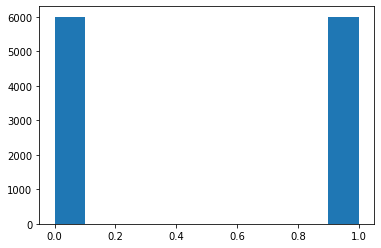

In [45]:
plt.hist(df['non_science'])

In [46]:
#df.to_csv('dataset.csv')

In [47]:
#df = pd.read_csv('dataset.csv')

In [48]:
df

,term,label,word_count,clean_text,target,non_science
0,celesticetin,antibiotic,1,celesticetin,0,0
1,aminocoumarin resistant gyrB,antibiotic,3,aminocoumarin resistant gyrb,0,0
2,BPI,antibiotic,1,bpi,0,0
3,AxyXY-OprZ,antibiotic,1,axyxy oprz,0,0
4,ANT(2''),antibiotic,1,ant,0,0
...,...,...,...,...,...,...
11982,Jukebox Babe,non_science,2,jukebox babe,3,1
11983,Eurosta latifrons,non_science,2,eurosta latifrons,3,1
11984,Amana Colonies,non_science,2,amana colonies,3,1
11985,Zhao Linquan,non_science,2,zhao linquan,3,1


### **Model Selection**:



*   The challenge asks for better accuracy. In this case, it is a better idea to perform binary classification (i.e. science, non_science) using Logistic regression or Naive bayes. After that, another model can be used for multiclass classification to predict scientific terms.
  - I will use this approacch initially.

*   The simpler machine learning model struggles in prediction data of longer text length. RNN based neural networks perform better in this case.
  - I will try this model in the later section.



### **Model training and Evaluation:**

**Training to check 'non_science' and other scientific terms.**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df["non_science"], test_size=0.25, shuffle=True)

In [51]:
# Tf-Idf
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

#### 1) classify a term as scientific or non-scientific

In [104]:
# Logistic Regression
lr_tfidf = LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)

# Predict y value for test dataset
y_predict = lr_tfidf.predict(X_test_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
print(classification_report(y_test, y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

              precision    recall  f1-score   support

           0       0.99      0.90      0.94      1498
           1       0.91      0.99      0.95      1499

    accuracy                           0.94      2997
   macro avg       0.95      0.94      0.94      2997
weighted avg       0.95      0.94      0.94      2997

Confusion Matrix: [[1342  156]
 [  12 1487]]
AUC: 0.9787933833948935


In [53]:
# Naive Bayes
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_vectors_tfidf, y_train) 

# Predict y value for test dataset
y_predict = nb_tfidf.predict(X_test_vectors_tfidf)
y_prob = nb_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]

print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

              precision    recall  f1-score   support

           0       0.97      0.91      0.94      1498
           1       0.92      0.97      0.94      1499

    accuracy                           0.94      2997
   macro avg       0.94      0.94      0.94      2997
weighted avg       0.94      0.94      0.94      2997

Confusion Matrix: [[1369  129]
 [  46 1453]]
AUC: 0.9784872157762495


#### 2) if it is scientific, also classify it into a scientific category.

**Take terms containing only scientific terms.**

In [71]:
df_new = df[df['non_science'] == 0]
df_new.head()

,term,label,word_count,clean_text,target,non_science,clean_text_tok
0,celesticetin,antibiotic,1,celesticetin,0,0,[celesticetin]
1,aminocoumarin resistant gyrB,antibiotic,3,aminocoumarin resistant gyrb,0,0,"[aminocoumarin, resistant, gyrb]"
2,BPI,antibiotic,1,bpi,0,0,[bpi]
3,AxyXY-OprZ,antibiotic,1,axyxy oprz,0,0,"[axyxy, oprz]"
4,ANT(2''),antibiotic,1,ant,0,0,[ant]


In [72]:
df_new.drop(columns=['non_science'], axis=0)

,term,label,word_count,clean_text,target,clean_text_tok
0,celesticetin,antibiotic,1,celesticetin,0,[celesticetin]
1,aminocoumarin resistant gyrB,antibiotic,3,aminocoumarin resistant gyrb,0,"[aminocoumarin, resistant, gyrb]"
2,BPI,antibiotic,1,bpi,0,[bpi]
3,AxyXY-OprZ,antibiotic,1,axyxy oprz,0,"[axyxy, oprz]"
4,ANT(2''),antibiotic,1,ant,0,[ant]
...,...,...,...,...,...,...
5982,"4,4-dimethyl-5alpha-ergosta-8,24(28)-dien-3bet...",reagent,1,dimethyl alpha ergosta dien beta ol,5,"[dimethyl, alpha, ergosta, dien, beta, ol]"
5983,"N-[(2R,4aS,12aR)-5-methyl-2-(2-morpholin-4-yl-...",reagent,1,n r ar methyl morpholin yl oxoethyl oxo hexahy...,5,"[n, r, ar, methyl, morpholin, yl, oxoethyl, ox..."
5984,LSM-7338,reagent,1,lsm,5,[lsm]
5985,N-(L-arginino) taurine,reagent,2,n l arginino taurine,5,"[n, l, arginino, taurine]"


In [74]:
# SPLITTING THE TRAINING DATASET
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(df_new["clean_text"], df_new["target"], test_size=0.25, shuffle=True)

# Word2Vec runs on tokenized sentences
X_train_tok_new = [nltk.word_tokenize(i) for i in X_train_new]
X_test_tok_new = [nltk.word_tokenize(i) for i in X_test_new]

In [75]:
#Tf-Idf
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf_new = tfidf_vectorizer.fit_transform(X_train_new) 
X_test_vectors_tfidf_new = tfidf_vectorizer.transform(X_test_new)

**Logistic Regression**

In [78]:
# FITTING THE CLASSIFICATION MODEL using Logistic Regression(tf-idf)
lr_tfidf = LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf_new, y_train_new)

# Predict y value for test dataset
y_predict_new = lr_tfidf.predict(X_test_vectors_tfidf_new)
y_prob_new = lr_tfidf.predict_proba(X_test_vectors_tfidf_new)[:,1]
print(classification_report(y_test_new, y_predict_new))

              precision    recall  f1-score   support

           0       0.98      0.86      0.91       207
           1       1.00      0.95      0.97       298
           2       0.99      0.97      0.98       314
           4       0.97      0.98      0.98       330
           5       0.87      0.98      0.92       348

    accuracy                           0.95      1497
   macro avg       0.96      0.95      0.95      1497
weighted avg       0.96      0.95      0.95      1497



#### **RNN approach**:

In [50]:
X_train, X_test, y_train, y_test = train_test_split(sequence_text, df["non_science"], test_size=0.25, shuffle=True)

In [51]:
sequence_input = Input(shape=(maxlen,))
embedded_sequences = Embedding(len(tokenizer.word_index) + 1, ft.vector_size, 
                weights=[embedding_matrix_ft], trainable=False)(sequence_input)

l_lstm = Bidirectional(LSTM(100))(embedded_sequences)
preds = Dense(1, activation='softmax')(l_lstm)
model = Model(sequence_input, preds)

In [52]:
model.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=['acc'])

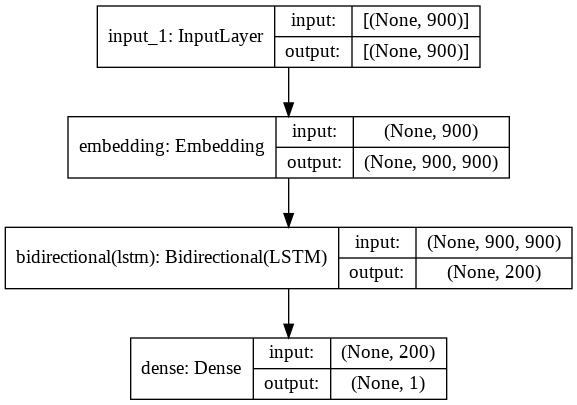

In [53]:
plot_model(model, to_file='classification_model.png', show_shapes=True)

In [54]:
H = model.fit(X_train, y_train, epochs=3, batch_size=64)

Epoch 1/3
141/141 [==============================] - 62s 378ms/step - loss: 0.0000e+00 - acc: 0.4980
Epoch 2/3
141/141 [==============================] - 53s 379ms/step - loss: 0.0000e+00 - acc: 0.4980
Epoch 3/3
141/141 [==============================] - 53s 378ms/step - loss: 0.0000e+00 - acc: 0.4980


In [55]:
# Save model
model.save('classification_model.h5')

In [60]:
def plot_graphs(H, metric):
    num_epochs = 3
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, num_epochs), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, num_epochs), H.history["acc"], label="train_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.savefig("model_history")
    plt.show()

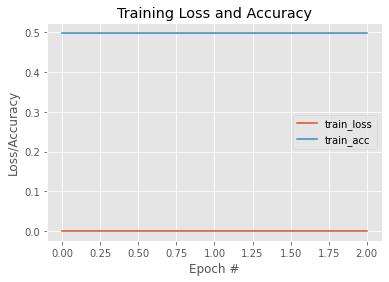

In [61]:
plot_graphs(H, 'acc')

**Prediction on the wikipedia texts:**

In [62]:
model.predict(sequence_test)

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

### **Final verdict on model accuracy**

I received very good accuracy, precision and recall values with generic machine learning classification approach on the training data. If we can preprocss test data to a satisfactory length, we can use it on the prediction texts.


The RNN approach seems to be underfitted. It might work well with hyperparameter tuning and more cleaned prediction data.